In [1]:
pip install opencv-python

In [2]:
pip install tqdm

In [3]:
pip install seaborn

In [4]:
import os, cv2, random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
%matplotlib inline 

In [5]:
TEST_SIZE = 0.5
RANDOM_STATE = 2020
BATCH_SIZE = 64
NO_EPOCHS = 10
NUM_CLASSES = 2
IMG_SIZE = 224


In [6]:
!unzip /content/drive/MyDrive/test_data_224.zip -d /content/drive/MyDrive/dogs_cats/

Archive:  /content/drive/MyDrive/test_data_224.zip
replace /content/drive/MyDrive/dogs_cats/test_data_224.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
!unzip /content/drive/MyDrive/train_data_224.zip -d /content/drive/MyDrive/dogs_cats/

Archive:  /content/drive/MyDrive/train_data_224.zip
  inflating: /content/drive/MyDrive/dogs_cats/train_data_224.npy  


In [8]:
train_data = np.load('/content/drive/MyDrive/dogs_cats/train_data_224.npy',allow_pickle=True)
test_data = np.load('/content/drive/MyDrive/dogs_cats/test_data_224.npy',allow_pickle=True)

# New Section

In [9]:
X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train_data])

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [11]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/10
196/196 [==============================] - 97s 407ms/step - loss: 2.3491 - accuracy: 0.8638 - val_loss: 0.2461 - val_accuracy: 0.9045
Epoch 2/10
196/196 [==============================] - 77s 391ms/step - loss: 0.1041 - accuracy: 0.9611 - val_loss: 0.1107 - val_accuracy: 0.9587
Epoch 3/10
196/196 [==============================] - 76s 390ms/step - loss: 0.0365 - accuracy: 0.9883 - val_loss: 0.1066 - val_accuracy: 0.9631
Epoch 4/10
196/196 [==============================] - 76s 390ms/step - loss: 0.0157 - accuracy: 0.9958 - val_loss: 0.1098 - val_accuracy: 0.9632
Epoch 5/10
196/196 [==============================] - 76s 391ms/step - loss: 0.0080 - accuracy: 0.9983 - val_loss: 0.1056 - val_accuracy: 0.9665
Epoch 6/10
196/196 [==============================] - 76s 390ms/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.1198 - val_accuracy: 0.9646
Epoch 7/10
196/196 [==============================] - 76s 391ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.1240 - val_ac

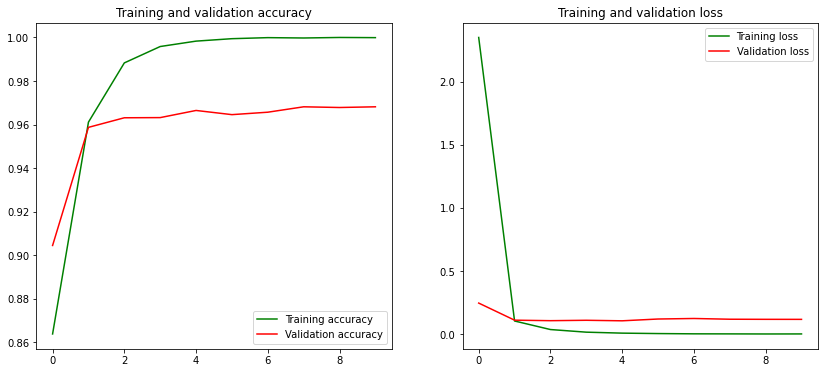

In [20]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [21]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.11705584824085236
Validation accuracy: 0.9681599736213684


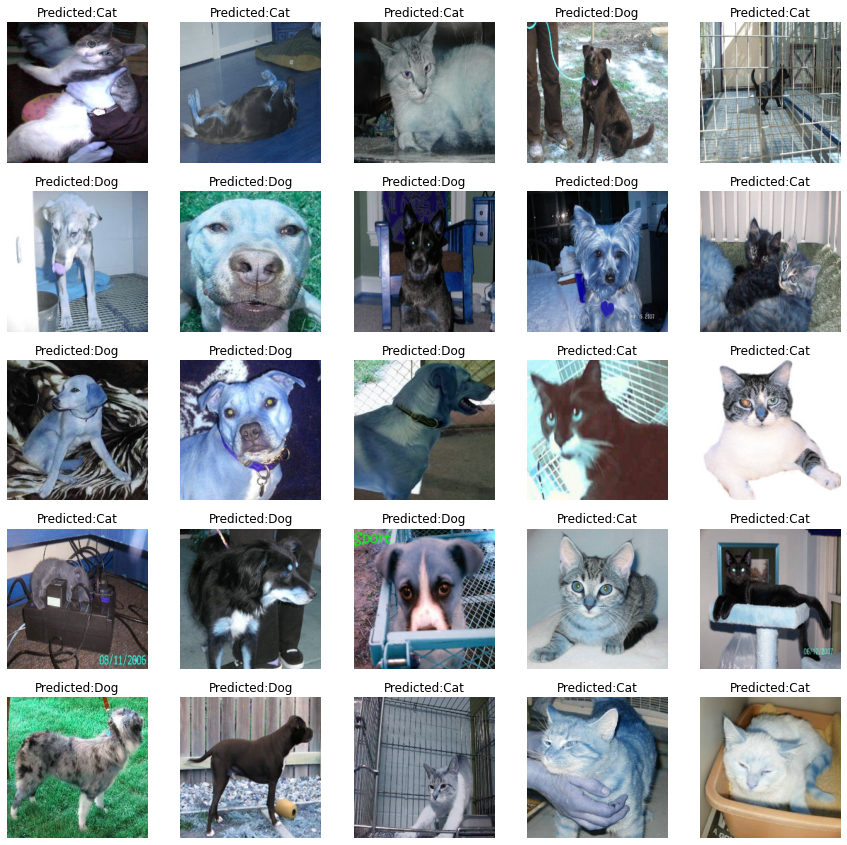

In [22]:
f, ax = plt.subplots(5,5, figsize=(15,15))
for i,data in enumerate(test_data[:25]):
    img_num = data[1]
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_predicted='Dog'
    else: 
        str_predicted='Cat'
    ax[i//5, i%5].imshow(orig)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(str_predicted))    
plt.show()

In [23]:
pred_list = []
img_list = []
for img in tqdm(test_data):
    img_data = img[0]
    img_idx = img[1]
    data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
    predicted = (model.predict([data])[0])
    img_list.append(img_idx)
    pred_list.append(round(predicted[1]))

100%|██████████| 12500/12500 [10:36<00:00, 19.63it/s]


In [26]:
submission = pd.DataFrame({'id':img_list , 'label':pred_list})
submission.head()
submission.to_csv("submission_resnet50_224.csv", index=False)